ProgEcon: Project 1

Group: Nikolaj and Fanny

In [245]:
import numpy as np
import pandas as pd
import matplotlib.dates as mdates

# APIs
from fredapi import Fred
from dstapi import DstApi

# plotting
import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({'axes.grid':True,'grid.color':'black','grid.alpha':'0.25','grid.linestyle':'--'})
plt.rcParams.update({'font.size': 14})

# 1. Aggregate inflation in Denmark

## 1.1 Basic


In [246]:
PRIS113 = DstApi('PRIS113')  
PRIS113.tablesummary(language='en')

Table PRIS113: Consumer price index by type and time
Last update: 2025-10-10T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,TYPE,1,INDEKS,Consumer price index,INDEKS,Consumer price index,False
1,Tid,549,1980M01,1980M01,2025M09,2025M09,True


In [247]:
# a) set download parameters
params = {
    'table': 'PRIS113',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'TYPE', 'values': ['INDEKS']},  # CPI
        {'code': 'TID',  'values': ['*']}        # Time 
    ]
}
# b) download
cpi = PRIS113.get_data(params=params)

# c) display
display(CPI.head(5))
display(CPI.info())

# d) Renaming varibles
cpi = cpi.rename(columns={'INDHOLD': 'P'})
cpi['Time'] = pd.to_datetime(cpi['TID'], format='%YM%m')
cpi = cpi.sort_values('Time').reset_index(drop=True)

# e) Change type 
cpi['P'] = cpi['P'].astype(float)

# f) Index
m2020 = cpi['Time'].dt.year == 2020
base = cpi.loc[m2020, 'P'].mean()
cpi['P_2020=100'] = cpi['P'] / base * 100

# g) Inflation
cpi['pi'] = cpi['P'].pct_change(1) # month to month inflation 
cpi['pi12'] = cpi['P'].pct_change(12) # 12-month inflation

# h) drop columns 
cpi.drop(columns = ['TYPE', 'TID'])
display(cpi.head())


,TYPE,TID,INDHOLD
0,Consumer price index,1980M01,33.0
1,Consumer price index,1980M05,34.5
2,Consumer price index,1980M09,35.5
3,Consumer price index,1981M01,36.5
4,Consumer price index,1981M05,38.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   TYPE     549 non-null    object
 1   TID      549 non-null    object
 2   INDHOLD  549 non-null    object
dtypes: object(3)
memory usage: 13.0+ KB


None

,TYPE,TID,P,Time,P_2020=100,pi,pi12
0,Consumer price index,1980M01,33.0,1980-01-01,31.904608,NaN,NaN
1,Consumer price index,1980M02,33.3,1980-02-01,32.194650,0.009091,NaN
2,Consumer price index,1980M03,33.8,1980-03-01,32.678053,0.015015,NaN
3,Consumer price index,1980M04,34.0,1980-04-01,32.871415,0.005917,NaN
4,Consumer price index,1980M05,34.5,1980-05-01,33.354818,0.014706,NaN


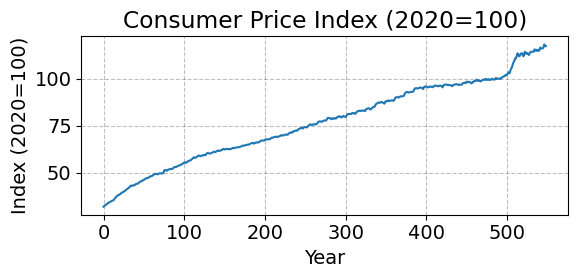

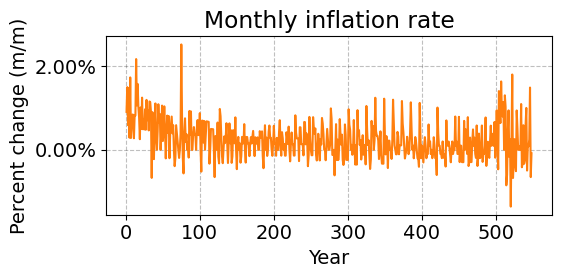

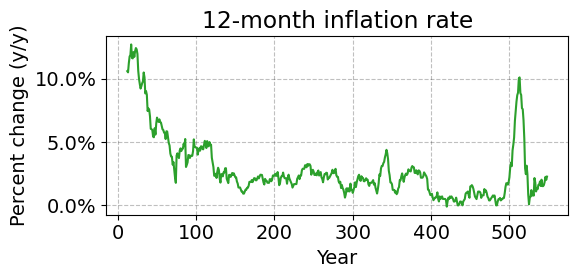

In [248]:
#Figures

# a) Index
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(cpi.index, cpi['P_2020=100'], color=colors[0])
ax.set_title('Consumer Price Index (2020=100)')
ax.set_xlabel('Year')
ax.set_ylabel('Index (2020=100)')
plt.tight_layout()
plt.show()

# b) month to month inflation
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(cpi.index, cpi['pi'], color=colors[1])
ax.set_title('Monthly inflation rate')
ax.set_xlabel('Year')
ax.set_ylabel('Percent change (m/m)')
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
plt.tight_layout()
plt.show()

# c) 12-month inflation
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(cpi.index, cpi['pi12'], color=colors[2])
ax.set_title('12-month inflation rate')
ax.set_xlabel('Year')
ax.set_ylabel('Percent change (y/y)')
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
plt.tight_layout()
plt.show()

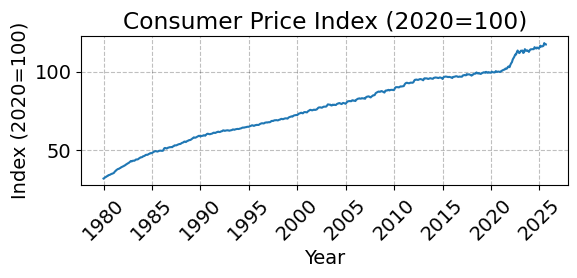

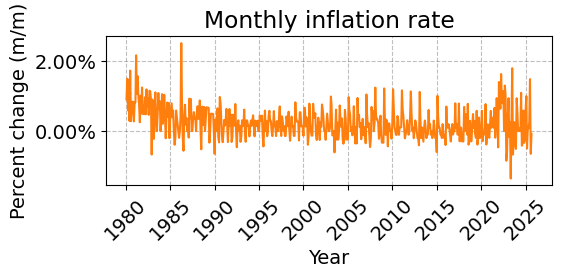

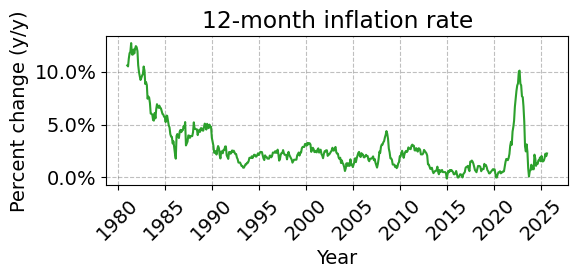

In [300]:
#Figures

# a) Index
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(cpi['Time'], cpi['P_2020=100'], color=colors[0])
ax.set_title('Consumer Price Index (2020=100)')
ax.set_xlabel('Year')
ax.set_ylabel('Index (2020=100)')
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

# b) month to month inflation
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(cpi['Time'], cpi['pi'], color=colors[1])
ax.set_title('Monthly inflation rate')
ax.set_xlabel('Year')
ax.set_ylabel('Percent change (m/m)')
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

# c) 12-month inflation
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(cpi['Time'], cpi['pi12'], color=colors[2])
ax.set_title('12-month inflation rate')
ax.set_xlabel('Year')
ax.set_ylabel('Percent change (y/y)')
ax.yaxis.set_major_formatter(plt.matplotlib.ticker.PercentFormatter(1.0))
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()

## 1.2 Instantaneous
$$
\begin{align*}
\pi_t^{12,\alpha} &= \left( \prod_{k=0}^{11} (1 + \pi_{t-k})^{\kappa(k,\alpha)} \right) - 1, \\[6pt]
\kappa(k,\alpha) &= \frac{(T - k)^{\alpha}}{\sum (T - k)^{\alpha} \, }T
\end{align*}
$$

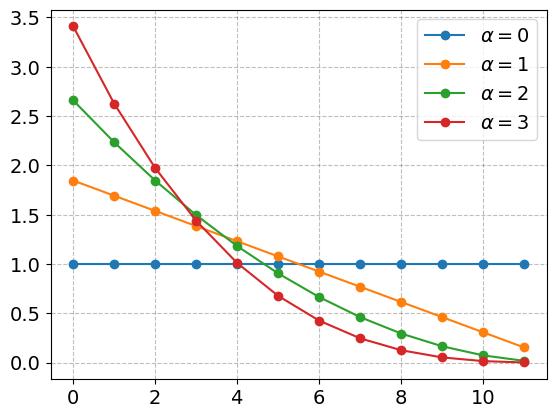

In [301]:
# Define kappa

def kappa(alpha, T=12):
    k = np.arange(T); return k, (T - k)**alpha / np.sum((T - np.arange(T))**alpha) * T

# The weight for alpha
alphas = [0, 1, 2, 3]

#the plot 
for a in alphas:
    k, w = kappa(a)
    plt.plot(k, w, marker='o', label=fr'$\alpha={a}$')
plt.legend()
plt.show()

plt.show()

In [302]:
def inflation_year(pi, alpha, T=12):
    _, w_k = kappa(alpha, T)
    w = w_k[::-1]  

    # Rolling 
    res = pi.rolling(12).apply(
        lambda x: np.prod((1 + x)**w) - 1,
        raw=True
    )
    return res

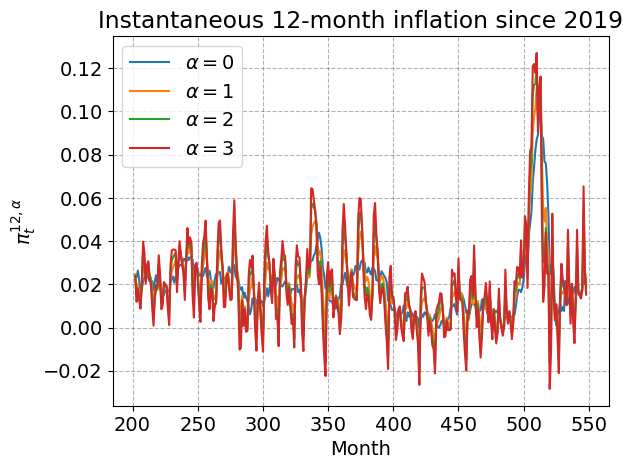

In [303]:
# Plot instantaneous inflation since 2019
for a in alphas:
    pi_year = inflation_year(pi, a)            # Beregn π_t^{12,α} med din eksisterende funktion
    plt.plot(pi_year.loc['2019':], label=fr'$\alpha={a}$')

plt.title("Instantaneous 12-month inflation since 2019")
plt.ylabel(r'$\pi_t^{12,\alpha}$')
plt.xlabel("Month")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


## 1.3 Core inflation

In [304]:
PRIS111 = DstApi('PRIS111')  
PRIS111.tablesummary(language='en')

Table PRIS111: Consumer price index by commodity group, unit and time
Last update: 2025-10-10T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,VAREGR,385,000000,"00 Consumer price index, total",151000,15.1 Overall Consumer Price Index excl. energy,False
1,ENHED,3,100,Index,300,Percentage change compared to same month the y...,False
2,Tid,297,2001M01,2001M01,2025M09,2025M09,True


In [305]:
# --- 1. hent data fra PRIS111 ---
params_v2 = {
    'table': 'PRIS111',
    'format': 'BULK',
    'lang': 'en',
    'variables': [
        {'code': 'VAREGR', 'values': ['000000', '151000', '141000']},  # total, excl. energy, core
        {'code': 'ENHED',  'values': ['100']},                         # "Index"
        {'code': 'Tid',    'values': ['*']}                            # all months
    ]
}

cpi_v2 = PRIS111.get_data(params=params_v2)

display(cpi_v2.head())

# Renaming and sorting
cpi_v2 = cpi_v2.rename(columns={'INDHOLD':'P', 'TID':'Time'})
cpi_v2['Time'] = pd.to_datetime(cpi_v2['Time'], format='%YM%m')
cpi_v2['P'] = pd.to_numeric(cpi_v2['P'], errors='coerce')
cpi_v2 = cpi_v2.sort_values(['VAREGR','Time']).reset_index(drop=True)


,VAREGR,ENHED,TID,INDHOLD
0,14.1 Overall Consumer Price Index - excl. ener...,Index,2001M01,77.4
1,15.1 Overall Consumer Price Index excl. energy,Index,2001M01,77.4
2,"00 Consumer price index, total",Index,2001M01,76.7
3,"00 Consumer price index, total",Index,2004M06,82.7
4,"00 Consumer price index, total",Index,2007M10,87.5


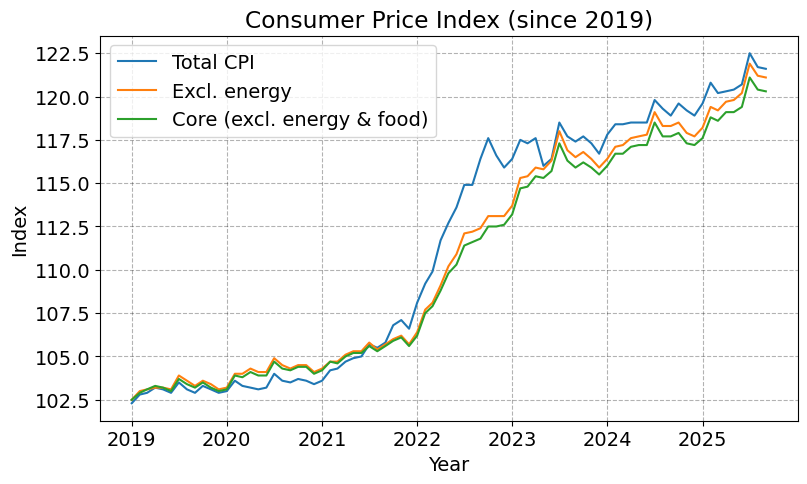

In [306]:

# Plot since 2019
series_dict = {
    'Total CPI'                     : cpi_v2['VAREGR'].str.startswith('00 '),
    'Excl. energy'                  : cpi_v2['VAREGR'].str.startswith('15.1 '),
    'Core (excl. energy & food)'    : cpi_v2['VAREGR'].str.startswith('14.1 ')
}

fig, ax = plt.subplots(figsize=(9,5))
for name, mask in series_dict.items():
    df = cpi_v2.loc[mask]
    df = df[df['Time'] >= '2019-01-01']
    ax.plot(df['Time'], df['P'], label=name)

ax.set_title("Consumer Price Index (since 2019)")
ax.set_xlabel("Year")
ax.set_ylabel("Index")
ax.legend()
ax.grid(alpha=0.3)
plt.show()


## 1.4 Disaggregated inflation in Denmark

# 2. International Comparison

## 2.1 CPI vs HICP

## 2.2 Across countries

# 3. Extension